# ✐ Détection de motifs par filtrage adapté

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Émetteur

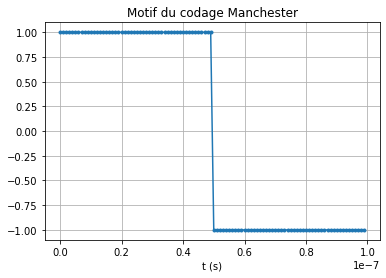

In [2]:
# Motif

T = 1e-7
fe = 1e9
Te = 1/fe
t = np.arange(0, T, Te)
motif = np.where(t<T/2, 1, -1)

plt.figure()
plt.plot(t, motif, ".-")
plt.title("Motif du codage Manchester")
plt.xlabel("t (s)")
plt.grid()
plt.show()

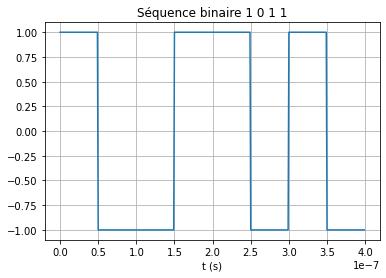

In [3]:
# Séquence binaire
B = 4
x = np.concatenate((motif, -motif, motif, motif))
t2 = np.arange(0, B*T, Te)

plt.figure;
plt.plot(t2,x);
plt.title("Séquence binaire 1 0 1 1")
plt.xlabel("t (s)")
plt.grid()
plt.show()

## Canal de transmission

In [4]:
# Bruit gaussien (RSB = 10 dB)

snr = 10
N = len(x)
Px = np.linalg.norm(x)**2/N
sig = np.sqrt(Px * 10**(-snr/10))
b = np.random.normal(0, sig, N)
y = x + b

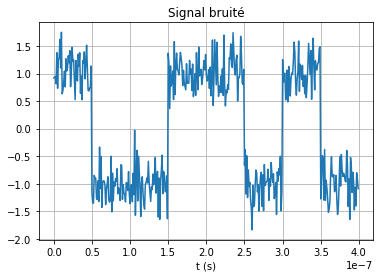

In [5]:
plt.figure()
plt.plot(t2,y)
plt.title("Signal bruité")
plt.xlabel("t (s)")
plt.grid()
plt.show()

## Récepteur

In [6]:
# Réponse impulsionnelle du filtre adapté

h = motif[::-1]

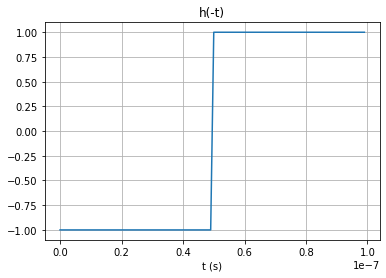

In [7]:
plt.figure()
plt.plot(t,h)
plt.title("h(-t)")
plt.xlabel("t (s)")
plt.grid()
plt.show()

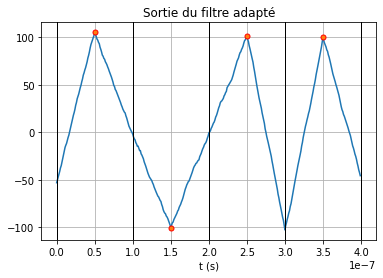

In [8]:
# Filtre adapté

z = np.convolve(y, h, "same")

# Échantillons d'intérêt du filtrage
idx = np.arange(B)*N/B + N/B/2
idx = idx.astype(int)
tx = t2[idx]
zx = z[idx]

# Affichage
plt.figure()
plt.plot(t2,z)
for t in T*np.arange(5):
    plt.axvline(t, color="black", linewidth=1)
plt.plot(tx, zx, ".", markeredgecolor="r", markersize=10)
plt.title("Sortie du filtre adapté")
plt.xlabel("t (s)")
plt.grid()
plt.show()

## Robustesse par rapport au bruit

L'exemple ci-dessus est reproduit pour différents RSB.

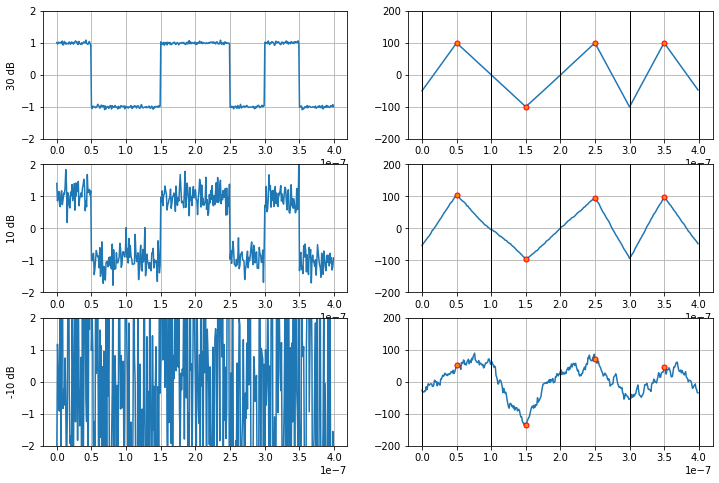

In [9]:
# Robustesse en fonction du RSB (avec l'exemple 1 0 1 1)

rsbs = [30, 10, -10]
M = len(rsbs)

fig = plt.figure(figsize=(12, 8))

for rsb in rsbs:
    
    # Bruit
    sig = np.sqrt(Px * 10**(-rsb/10))
    b = np.random.normal(0, sig, N)
    y = x + b
    
    # Affichage du signal bruité
    spi = len(fig.get_axes()) + 1
    plt.subplot(M, 2, spi)
    plt.plot(t2,y)
    plt.ylabel(f"{rsb} dB")
    plt.ylim([-2, 2])
    plt.grid()
    
    # Filtre adapté
    z = np.convolve(y, h, "same")
    zx = z[idx]
    
    # Affichage du filtrage adapté
    spi = len(fig.get_axes()) + 1
    plt.subplot(M, 2, spi)
    plt.plot(t2,z)
    for t in T*np.arange(5):
        plt.axvline(t, color="black", linewidth=1)
    plt.plot(tx, zx, ".", markeredgecolor="r", markersize=10)
    plt.ylim([-200, 200])
    plt.grid()

plt.show()

On peut approfondir l'étude en testant un grand nombre de RSB,
et pour chacun d'eux calculer le nombre d'erreurs de transmission,
c'est-à-dire le nombre de bits différents entre la séquence binaire émise et la séquence binaire identifiée par le récepteur.

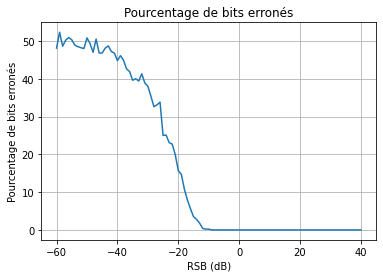

In [10]:
# Robustesse en fonction du RSB (étude plus poussée) :
# pourcentage d'erreurs sur une séquence plus longue

B = 1000
m = np.random.randint(2, size=B)
x = np.kron( 2*m-1, motif)
N = len(x)
rsbs = np.arange(-60,41)
Pe = []

for rsb in rsbs:
    
    # Bruit
    sig = np.sqrt(Px * 10**(-rsb/10))
    b = np.random.normal(0, sig, N)
    y = x + b
    
    # Filtre adapté
    z = np.convolve(y, h, "same")
    
    # Décodage
    idx = np.arange(B)*N/B + N/B/2
    idx = idx.astype(int)
    zx = z[idx]
    r = zx > 0
    
    # Pourcentage de bits biens reçus
    Nb = np.sum(r!=m)
    Pe.append(Nb/B*100)
        
plt.figure()
plt.plot(rsbs,Pe)
plt.title("Pourcentage de bits erronés")
plt.xlabel("RSB (dB)")
plt.ylabel("Pourcentage de bits erronés")
plt.grid()
plt.show()

* Comme on pouvait s'y attendre, le nombre d'erreur diminue lorsque le RSB augmente.
* On remarque par ailleurs que si le RSB est supérieur à $-10$ dB, il n'y a aucune erreur détectée,
  ce qui montre que le filtre adapté est une méthode très robuste au bruit !
* Il y a une stagnation du pourcentage d'erreurs à environ 50 % pour un RSB inférieur à $-40$ dB :
  dans ces conditions, le bruit est tellement fort que le filtre adapté se comporte comme un générateur aléatoire indépendant du message émis.

## Décodage du signal manchester.csv

[1 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1]


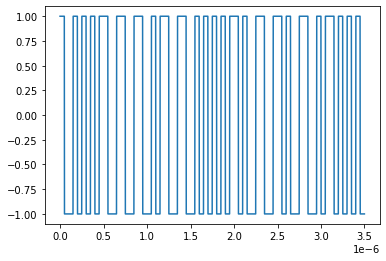

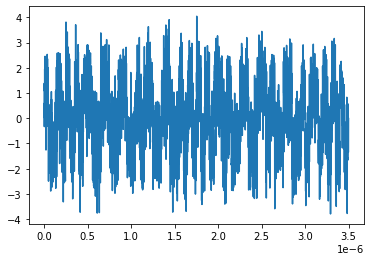

In [11]:
# Signal manchester.csv

# Texte
texte = "BRAVO"

# Liste des caractères en ASCII (représentation en entiers)
chi = [ord(c) for c in texte]

# Liste des caractères en ASCII (représentation binaire)
chb = ["{:b}".format(c) for c in chi]

# Séquence binaire
m = np.array([int(item) for sublist in chb for item in sublist])
print(m)

# Message (envoyé)
x = np.kron( 2*m-1, motif)
N = len(x)
t = np.arange(N)*Te

plt.figure()
plt.plot(t,x)
plt.show()

# Message reçu
snr = 0
Px = np.linalg.norm(x)**2/N
sig = np.sqrt(Px * 10**(-snr/10))
b = np.random.normal(0, sig, N)
y = x + b

plt.figure()
plt.plot(t,y)
plt.show()

# Enregistrement
np.savetxt("../_static/files/manchester.csv", y, delimiter=',')

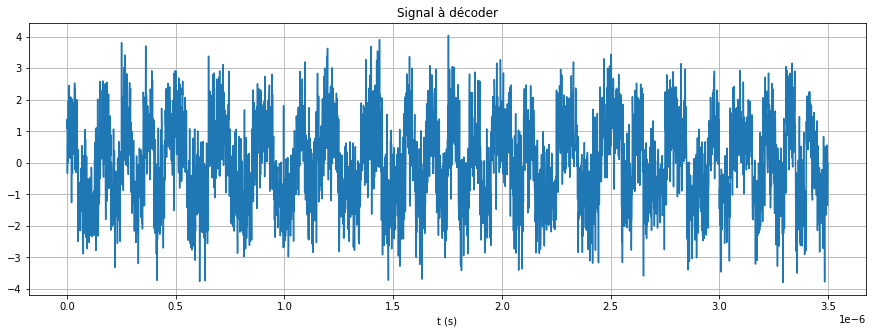

In [12]:
# Application au signal manchester.csv

# Chargement du signal
y = np.loadtxt("../_static/files/manchester.csv", delimiter=',')
N = len(y)
t = np.arange(N)*Te

# Affichage
plt.figure(figsize=(15,5))
plt.plot(t,y)
plt.title("Signal à décoder")
plt.xlabel("t (s)")
plt.grid()
plt.show()

# Filtre adapté
z = np.convolve(y, h, "same")

# Échantillonnage
M = round(T/Te)
zx = z[int(M/2)::M]
B = len(zx)

# Seuillage
r = 1 * (zx>0)

# Décodage
texte = ""
for n in range(0,B,7):
    chb = r[n:n+7]
    toto = [str(i) for i in chb]
    titi = "".join(toto)
    chi = int(titi, 2)
    texte += chr(chi)

La séquence décodée est :

In [13]:
print(r)

[1 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1]


Ce qui, en regroupant les bits 7 par 7 (code ASCII) permet d'obtenir le message :

In [14]:
print(texte)

BRAVO
